In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.nn.init import kaiming_uniform_

In [2]:
import numpy as np
import gym
from tqdm import tqdm
import random as rand
from itertools import count

In [43]:
class OU_noise():
    def __init__(self,mu,sigma=0.3,theta=0.15,dt=1e-5,x0=None):
        self.theta = theta
        self.mu    = mu
        self.sigma = sigma
        self.dt    = dt
        self.x0    = x0
        self.reset()
        
    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev)* \
                self.dt +self.sigma * np.sqrt(self.dt)*np.random.normal(size = self.mu.shape)
        self.x_prev = x
        return x
    
    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

In [44]:
class ReplayMemory():
    def __init__(self,capacity):   
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count%self.capacity] = experience
        self.push_count+=1
    
    def sample(self, batch_size):
        return rand.sample(self.memory,batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory)>=batch_size
    
    def update_td_error(self, sampled_experiences):
        for sampled_idx,sampled_exp in enumerate(sampled_experiences):
            for mem_idx, mem_exp in enumerate(self.memory):
                if mem_exp.timestep == sampled_exp.timestep:
                    self.memory[mem_idx] = sampled_exp #update memory
                    break
        
    def get_memory_values(self):
        return self.memory    

In [45]:
def extract_tensors(experiences):
    #print(".....................................................")
    #print(experiences)
    batch = Xp(*zip(*experiences))
    state = np.stack(batch.state) #stack
    action = np.stack(batch.action)
    next_state = np.stack(batch.next_state)
    reward = np.stack(batch.reward)
    done = np.stack(batch.done)
    abs_td_error = np.stack(batch.abs_td_error)
    timestep = np.stack(batch.timestep)
    return state,action,next_state,reward,done,abs_td_error,timestep

In [46]:
def rebuild_experiences(state, action, next_state, reward, done, abs_error, timestep):
    exp_list = []
    for idx_ in range(len(state)):
        exp_list.append(\
                        Xp(state[idx_], action[idx_], next_state[idx_], reward[idx_],\
                           done[idx_], abs_error[idx_], timestep[idx_]))
    return exp_list

In [47]:
from collections import namedtuple
Xp = namedtuple('Experience',
                        ('state', 'action', 'next_state', 'reward', 'done', 'abs_td_error','timestep'))
Xp_points = Xp(5,6,7,8,9,10,11)
Xp_points

Experience(state=5, action=6, next_state=7, reward=8, done=9, abs_td_error=10, timestep=11)

In [48]:
class linearApproximator_FCDCAP(nn.Module):
    def __init__(self,state_shape,outputs,hidden_dims=(32,32)):
        super(linearApproximator_FCDCAP, self).__init__()
        self.input_size = state_shape
        self.out = outputs
        self.device = torch.device("cuda" if torch.cuda.is_available()\
                                   else "cpu")
        
        self.fc1  = nn.Linear(self.input_size,hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(\
                                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        
        self.output_layer  = nn.Linear(hidden_dims[-1],self.out)
        self.tan_h = torch.nn.Tanh()
        self.to(self.device)
        
    def forward(self, state_shape):
        if not isinstance(state_shape, torch.Tensor):
            state_shape = torch.tensor(state_shape, dtype=torch.float32)
        state_shape = state_shape.to(self.device)
            
        x = self.fc1(state_shape)
        x = F.relu(x)
        
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        
        unscaled_output = self.output_layer(x)#logits, preferences of actions
        scaled_output = self.tan_h(unscaled_output)*2
        return scaled_output

In [49]:
class linearApproximator_FCQV(nn.Module):#Q value of state action pair
    def __init__(self,state_shape,action_outputs_size,hidden_dims=(32,32)):
        super(linearApproximator_FCQV, self).__init__()
        self.input_size = state_shape
        self.action_outputs_size = action_outputs_size
        self.device = torch.device("cuda" if torch.cuda.is_available()\
                                   else "cpu")
        
        self.fc1  = nn.Linear(self.input_size,hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_input_layer = hidden_dims[i]
            if i == 0:
                hidden_input_layer += self.action_outputs_size #increased to account for size/number of actions
            hidden_layer = nn.Linear(\
                                hidden_input_layer, hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        
        self.output_layer  = nn.Linear(hidden_dims[-1],1)
        self.tan_h = torch.nn.Tanh()
        self.to(self.device)
        
    def forward(self, state_shape, action_shape):
        if not isinstance(state_shape, torch.Tensor):
            state_shape = torch.tensor(state_shape, dtype=torch.float32).to(self.device)
        if not isinstance(action_shape, torch.Tensor):
            action_shape = torch.tensor(action_shape, dtype=torch.float32).to(self.device)
                    
        x = self.fc1(state_shape)
        x = F.relu(x)
        
        for idx, hidden_layer in enumerate(self.hidden_layers):
            if idx == 0:
                x = torch.cat((x, action_shape), dim=1)
            x = F.relu(hidden_layer(x))
        
        q_value = self.output_layer(x)#logits, preferences of actions
        return q_value

In [50]:
def update_networks(online_policy_network, online_value_network,\
                    offline_policy_network, offline_value_network, tau):
    #polyak averaging: pg:319
    for target_weights, online_weights in zip(offline_policy_network.parameters(), online_policy_network.parameters()):
        target_weight_update = (1.0 - tau)*target_weights.data
        online_weight_update = tau*online_weights.data
        sum_up = target_weight_update + online_weight_update
        target_weights.data.copy_(sum_up)
        
    for target_weights, online_weights in zip(offline_value_network.parameters(), online_value_network.parameters()):
        target_weight_update = (1.0 - tau)*target_weights.data
        online_weight_update = tau*online_weights.data
        sum_up = target_weight_update + online_weight_update
        target_weights.data.copy_(sum_up)
    return offline_policy_network, offline_value_network

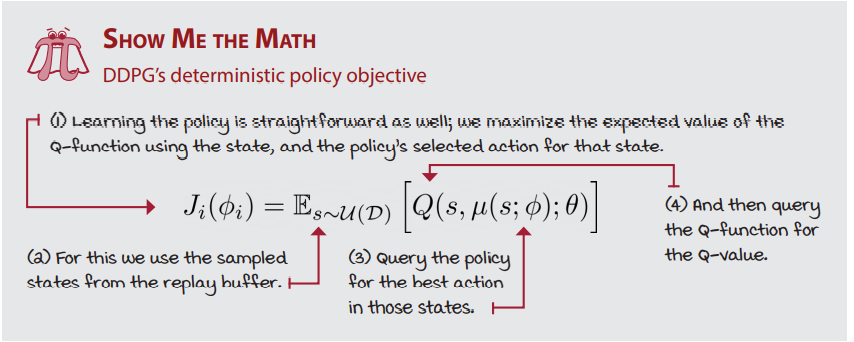

In [51]:
def update_online_model(experience_samples,\
                        online_policy_network, online_q_network,\
                        offline_policy_network, offline_q_network,\
                        online_policy_optimizer,online_value_optimizer,\
                        gamma, weighted_importance, indices):
    
    states, actions, next_states, rewards, done, td_errors, timesteps = extract_tensors(experience_samples)
    
    #rearrange first
    indices = np.array(indices)#have to be same size as batch size(already taken care of)
    indices = np.squeeze(indices)
    
    states = states[indices,:]
    states = np.squeeze(states)
    
    next_states = next_states[indices,:]
    next_states = np.squeeze(next_states)
    
    actions = actions[indices]
    rewards = rewards[indices]
    done = done[indices]
    td_errors = td_errors[indices]
    timesteps = timesteps[indices]    
    
    
    states = torch.tensor(states).float()
    actions = torch.tensor(actions)
    actions = actions.type(torch.LongTensor)
    next_states=torch.tensor(next_states).float()
    rewards = torch.tensor(rewards).float()
    rewards = rewards.unsqueeze(1)
    done = torch.tensor(done).float()
    done = done.unsqueeze(1)
    weighted_importance = torch.tensor(weighted_importance).float()
    
    
    q_offline_max_actions = offline_policy_network(next_states)#get 
    q_target_next_states_action = offline_q_network(next_states,\
                                                    q_offline_max_actions.detach())
    q_target_next_states_action *=(1 - done) #set terminal q vals to zero]
    q_target = rewards + (gamma*q_target_next_states_action.detach())
    #print("qt: ", q_target.shape)
    #q_target = q_target.detach()
    
    q_online_state_action_val = online_q_network(states, actions)
    #print("q_sa: ", q_online_state_action_val.shape)
    q_online_value_loss = torch.nn.SmoothL1Loss()
    q_online_state_action_val*=weighted_importance
    #print("q_sa prime: ", q_online_state_action_val.shape)
    q_target*=weighted_importance
    q_online_value_loss = q_online_value_loss(q_online_state_action_val,\
                                             q_target)
    
    absolute_error = abs(q_online_state_action_val.detach().cpu().numpy()\
                         - q_target.detach().cpu().numpy())
    absolute_error = np.squeeze(absolute_error)#used to update errors in memory
    
    online_value_optimizer.zero_grad()
    q_online_value_loss.backward()
    online_value_optimizer.step()
    
    #update policy_network
    q_online_max =online_policy_network(states)
    q_target = online_q_network(states,q_online_max)
    q_target*=weighted_importance
    online_policy_loss = -q_target.mean()
    
    online_policy_optimizer.zero_grad()
    online_policy_loss.backward()
    online_policy_optimizer.step()
    
    states, actions, next_states, rewards, done, td_errors, timesteps = extract_tensors(experience_samples)
    #print(experience_samples)
    experiences_rebuilded = rebuild_experiences(states, actions, next_states, rewards, done, absolute_error, timesteps)
    #print(experiences_rebuilded)
    return experiences_rebuilded

In [52]:
def query_error(offline_policy_network, offline_q_network,\
                online_q_network, state, next_state, action, reward, gamma):
    state = torch.tensor(state).float()
    state = state.unsqueeze(0)
    next_state = torch.tensor(next_state).float()
    next_state = next_state.unsqueeze(0)
    
    q_offline_max_actions = offline_policy_network(next_state)
    
    q_target_next_states_action = offline_q_network(next_state,\
                                                    q_offline_max_actions)
    q_target = reward + (gamma*q_target_next_states_action.detach())
    action = np.expand_dims(action, axis=0)
    #print("action after: ", action.shape)
    q_online_state_action_val = online_q_network(state, action)
    
    abs_error = abs(q_target - q_online_state_action_val)
    abs_error = np.squeeze(abs_error)
    #print("abs: ",abs_error )
    return abs_error.detach().cpu().numpy()

In [53]:
def prioritize_samples(experience_samples, alpha, beta):
    state,action,next_state,reward,done,abs_td_error,timesteps = extract_tensors(experience_samples)
    #rank based
    #('state', 'action', 'next_state', 'reward', 'done', 'abs_td_error','timestep')
    abs_td_error  = np.expand_dims(abs_td_error, axis=1)
    abs_td_error = torch.tensor(abs_td_error)
    abs_td_error, indices_ = abs_td_error.sort(0, descending=True)#big to small
    indices = np.arange(1, len(abs_td_error)+1)
    priorities = 1.0/indices
    priorities = priorities**alpha#scale by alpha
    priorities = np.expand_dims(priorities, axis=1)
    probabilities = priorities/np.sum(priorities, axis=0)#sums up to 1(or 0.999999)
    assert np.isclose(probabilities.sum(), 1.0)#ensures probs add up to 1
    
    number_of_samples  = len(probabilities)
    weight_importance_ = number_of_samples*probabilities
    weight_importance_ = weight_importance_**-beta
    weight_importance_max = np.max(weight_importance_)
    weight_importance_scaled = weight_importance_/weight_importance_max
    return weight_importance_scaled, indices_ #return weight important samples, return indices for re_arranging sampled experiences

In [54]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
    return model

In [55]:
def select_action(state, online_policy_network, noise):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state = torch.tensor(state).float().to(device)
    with torch.no_grad():
        max_action_value = online_policy_network(state).cpu().detach()
        max_action_value = max_action_value.data.numpy().squeeze()
        max_action_value = max_action_value + noise()
    return max_action_value

In [56]:
import time

In [63]:
def DDPG_PER(env,
         gamma=0.99,
         alpha_pr=0.6,
         beta_pr=0.3,
         memory_size = 5000,
         tau = 0.1,
         offline_update = 100,
         min_sample_size=320,
         batch_size = 30,
         n_ep=200,
         noise=1,
         max_steps = 100000
         ):
    
    
    observation_space = len(env.reset())
    
    n_actions = 1
    online_policy_network = linearApproximator_FCDCAP(observation_space,n_actions,\
                                     hidden_dims=(128,64))
    online_q_network = linearApproximator_FCQV(observation_space,\
                                     n_actions,hidden_dims=(128,64))
    
    offline_policy_network = linearApproximator_FCDCAP(observation_space,n_actions,\
                                     hidden_dims=(128,64))
    offline_q_network = linearApproximator_FCQV(observation_space,\
                                     n_actions,hidden_dims=(128,64))
    
    noise_ = OU_noise(np.zeros((n_actions)))
    offline_policy_network.eval()
    offline_policy_network = freeze_model(offline_policy_network)
    offline_q_network.eval()
    offline_q_network = freeze_model(offline_q_network)
    
    
    online_policy_optimizer    = torch.optim.Adam(online_policy_network.parameters(),lr=0.0008)
    online_q_network_optimizer = torch.optim.Adam(online_q_network.parameters(),lr=0.0008)
    
    memory = ReplayMemory(memory_size)
    
    t_step = 0 #important
    reward_per_ep = []
    
    
    for e in tqdm(range(n_ep)):
        state = env.reset()
        reward_accumulated = 0
        
        while True:
            env.render()
            action = select_action(state, online_policy_network, noise_)
            
            next_state, reward, done, info = env.step(action)
            td_error = query_error(offline_policy_network, offline_q_network,\
                            online_q_network, state, next_state, action, reward, gamma)
            
            reward_accumulated+=reward
            is_truncated = 'TimeLimit.truncated' in info and\
                                info['TimeLimit.truncated']
            is_failure = done and not is_truncated
           
            memory.push(Xp(state, action, next_state, reward, is_failure, td_error, t_step))
            state = next_state
            t_step+=1
            if memory.can_provide_sample(min_sample_size):
                experience_samples = memory.sample(batch_size)
                weighted_importance, indices = prioritize_samples(experience_samples, alpha_pr, beta_pr)
                rebuilded_exp = update_online_model(experience_samples,\
                                    online_policy_network, online_q_network,\
                                    offline_policy_network, offline_q_network,\
                                    online_policy_optimizer, online_q_network_optimizer,\
                                    gamma, weighted_importance, indices)
                memory.update_td_error(rebuilded_exp)
                
            if t_step%offline_update == 0:
                offline_policy_network, offline_q_network = update_networks(online_policy_network, online_q_network,\
                                                                offline_policy_network, offline_q_network, tau)
            if done == True:
                reward_per_ep.append(reward_accumulated)
                #print(reward_accumulated)
                break
            if t_step > max_steps:
                env.close()
                return reward_per_ep
    env.close()           
    return reward_per_ep

In [64]:
#env = gym.make("MountainCarContinuous-v0")
env = gym.make("Pendulum-v0")

In [65]:
env.action_space

Box(-2.0, 2.0, (1,), float32)

In [66]:
env.close()

In [78]:
rewards = DDPG_PER(env)  

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [19:44<00:00,  5.92s/it]


In [68]:
from scipy.ndimage.filters import uniform_filter1d
arr = uniform_filter1d(rewards, size=1)

In [69]:
from matplotlib import pyplot as plt
x = []
y = []
for i,e in enumerate(arr):
    y.append(i)
    x.append(e)

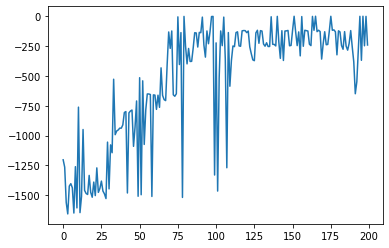

In [77]:
plt.plot(y, x)